<a href="https://colab.research.google.com/github/nmuthuk1/Python-Basics-HW/blob/master/Copy_neural_coding_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Upgrade seaborn for colab
!pip install -U seaborn

    100% |████████████████████████████████| 215kB 26.4MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
sns.set(font_scale=1.5)

## Let's load some data obtained by the Buzsaki lab at NYU.  They recorded from the hippocampus of a rat while it ran back and forth across a linear track

In [0]:
# The first file contains the times, cell IDs, and animal location for each spike that occurred
spikes = pd.read_csv('https://github.com/rgerkin/neuro-data-analysis-course/raw/master/data/place_cell_spike_data.csv')

# The first file contains the times, cell IDs, and animal location for each spike that occurred
locations = pd.read_csv('https://github.com/rgerkin/neuro-data-analysis-course/raw/master/data/place_cell_location_data.csv')

#### This first dataframe contains one row for each spike that was recorded.  The cell_id is arbitrary, but any two rows with the same cell id correspond to spikes reocrded from the same cell.  The index is time (starting several hours into the experiment), and the other columns are the linear location on the track ("d", measured from the track's left edge) and also the actual 2d coordinates ("x" and "y", which we will ignore). I've restricted the data to 0.2m < d < 1.4m, which is where the rat actually runs on the track (instead of sitting at the ends doing nothing).  

In [0]:
spikes = spikes.set_index('t')
spikes.head()

,cell_ids,d,x,y
t,,,,
18194.76930,609,0.200284,-0.061786,-0.189188
18194.77235,529,0.201205,-0.060900,-0.189143
18194.77305,1209,0.202125,-0.060015,-0.189098
18194.77855,416,0.203724,-0.058476,-0.189284
18194.77955,828,0.204402,-0.057822,-0.189515


#### The second dataframe contains one row for each ~25 ms of elapsed time.  They were recording the movement of the rat with a video camera, so each row is derived from one frame of that movie.  

In [0]:
locations = locations.set_index('t')
locations.head()

,d,x,y
t,,,
18194.776399,0.203045,-0.059129,-0.189053
18194.801998,0.213904,-0.048677,-0.192750
18194.827598,0.219871,-0.042934,-0.198324
18194.853198,0.225473,-0.037541,-0.203761
18194.878798,0.236299,-0.027121,-0.207461


## (1)

### (a)
#### Let's take a brief look at this data.  A good strategy is to figure out the range of your data (highs, lows, typical values) by making a histogram.  Access the "d" column of the locations dataframe, and then make a histogram with the `.hist()` method.  

#### You can use the default number of histogram bins, or change it with the "bins" argument (e.g. `.hist(bins=100)`).  You should see that the rat was on most of the track, slightly preferring the left-side (near d=0) to the right side.  

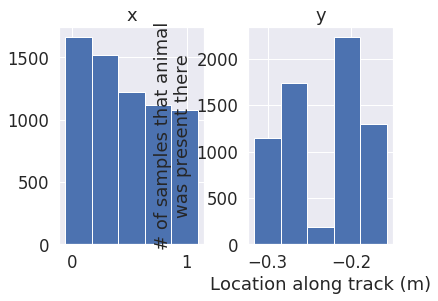

In [0]:
locations.set_index('d').hist(bins=5)
plt.xlabel('Location along track (m)')
plt.ylabel('# of samples that animal\nwas present there');

### (b)
#### Do the same thing with the `spikes` dataframe to see at what locations on the track the spikes occurred.  

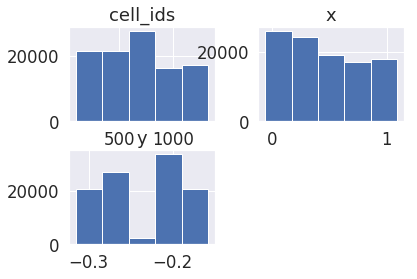

In [0]:
spikes.set_index('d').hist(bins=5)
plt.xlabel('Location along track (m)')
plt.ylabel('# of spikes observed there');

### (c)
#### That shows us the histogram, but we are actually going to want to use the values plotted there for our analysis.  Use the function `np.histogram` to extract the counts in each bin (the number of video frames that the rat was at that approximate location), and the locations of the edges of each bin, using 64 bins.  

In [0]:
frames_at_each_location, bin_edges = np.histogram(locations, bins=64)
frames_at_each_location
bin_edges

array([-0.31565554, -0.288851  , -0.26204646, -0.23524192, -0.20843738,
       -0.18163284, -0.1548283 , -0.12802376, -0.10121922, -0.07441468,
       -0.04761014, -0.0208056 ,  0.00599894,  0.03280348,  0.05960802,
        0.08641256,  0.11321711,  0.14002165,  0.16682619,  0.19363073,
        0.22043527,  0.24723981,  0.27404435,  0.30084889,  0.32765343,
        0.35445797,  0.38126251,  0.40806705,  0.43487159,  0.46167613,
        0.48848067,  0.51528521,  0.54208975,  0.56889429,  0.59569883,
        0.62250337,  0.64930791,  0.67611245,  0.70291699,  0.72972154,
        0.75652608,  0.78333062,  0.81013516,  0.8369397 ,  0.86374424,
        0.89054878,  0.91735332,  0.94415786,  0.9709624 ,  0.99776694,
        1.02457148,  1.05137602,  1.07818056,  1.1049851 ,  1.13178964,
        1.15859418,  1.18539872,  1.21220326,  1.2390078 ,  1.26581234,
        1.29261688,  1.31942142,  1.34622597,  1.37303051,  1.39983505])

#### If you check, you will see that there are 101 bin edges, not 100.  That is because each bin edge is both the left edge of one bin and the right edge of another.  Let's find the center of each bin, which is a better description of data in the bin.  

In [0]:
# This statement takes the average of the left-bin edges and the right-bin edges.  
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_centers = bin_centers.round(3)
bin_centers

array([-0.302, -0.275, -0.249, -0.222, -0.195, -0.168, -0.141, -0.115,
       -0.088, -0.061, -0.034, -0.007,  0.019,  0.046,  0.073,  0.1  ,
        0.127,  0.153,  0.18 ,  0.207,  0.234,  0.261,  0.287,  0.314,
        0.341,  0.368,  0.395,  0.421,  0.448,  0.475,  0.502,  0.529,
        0.555,  0.582,  0.609,  0.636,  0.663,  0.69 ,  0.716,  0.743,
        0.77 ,  0.797,  0.824,  0.85 ,  0.877,  0.904,  0.931,  0.958,
        0.984,  1.011,  1.038,  1.065,  1.092,  1.118,  1.145,  1.172,
        1.199,  1.226,  1.252,  1.279,  1.306,  1.333,  1.36 ,  1.386])

### (d) 
#### Notice that the histogram above is noisy.  Noisy data can cause problems with analysis, especially if we do lots of mathematical operations it.  It is sometimes better to work with smoothed data.  Below I show an example of something called gaussian smoothing, One trace below is original (fake) data, and the other is smoothed data. Change the smoothing_width to 3 to get some reasonably good smoothing.  

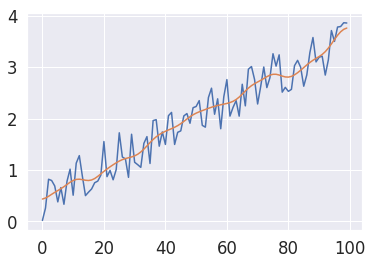

In [0]:
from scipy.ndimage.filters import gaussian_filter
noisy = np.linspace(0,3,100) + np.random.rand(100)
smoothing_width = 3
smooth = gaussian_filter(noisy, smoothing_width)
#smooth = gaussian_filter(noisy, 3)
plt.plot(noisy) # The blue trace
plt.plot(smooth); # The orange trace

### (e) 
#### Now let's smooth the location data.  First we need to figure out how long one video frame is.  They are all the same length, so we just need to subtract any two adjacent times in the index of the `locations` dataframe.  Then we need to multiply the number of frames at a given location by the duration of those frames to get the duration that the rat spent at each location.  Finally, we need to smooth those durations (using a smoothing width of 3).  

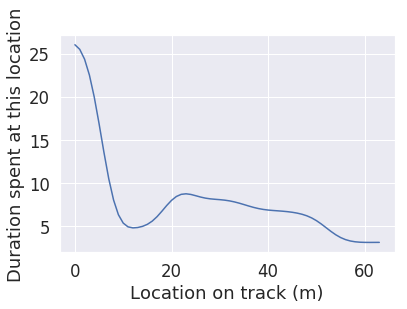

In [0]:
frame_duration = locations.index[1] - locations.index[0]
durations_at_each_location = frames_at_each_location * frame_duration
durations_at_each_location = gaussian_filter(durations_at_each_location, 3)
plt.plot(durations_at_each_location)
plt.xlabel('Location on track (m)')
plt.ylabel('Duration spent at this location');

## (2)

### (a)
#### Now that we know about how long the rat spent at each location, and from the `spikes` dataframe we know how many spikes occurred in each cell at each location, we can compute the firing rate (spikes per second) of each cell at each location.  First, I need to make an empty data frame to hold this data.  I will want to store the firing rate over the length of the track in each row of the data frame, so each row needs a cell ID associated with it.  Extract all the unique cell_ids in this dataset by applying the `.unique()` method to the `cell_ids` column of the `spikes` dataframe.  

In [0]:
cell_ids = spikes['cell_ids'].unique()
spike_rates = pd.DataFrame(index=cell_ids, columns=bin_centers)
spike_rates.index.name = 'Cell ID'
spike_rates.columns.name = 'Location on Track (m)'

### (b)
#### Now the fun part. I prepared a `for` loop, which will go through each of the cells (by id number) and then fill in the `spike_rates` data frame in the appropriate row.  The first line in that for loop requires you to get the subset of the `spikes` data that corresponds to only the current `cell_id`, using a selector.  In the second line you compute the histogram, so you get spike counts as a function of track location for one cell at a time.  In the third line you apply smoothing to stabilize the data.  In the fourth line you turn counts and durations into rates.  Finally, in the fifth line you fill the empty dataframe that we created above with the rate data that you computed for that cell.  

In [0]:
for cell_id in cell_ids:
    # 1
    is_it_this_cell_id = (spikes['cell_ids'] == cell_id)
    cell_spikes = spikes[is_it_this_cell_id]
    # 2
    spike_counts_at_each_location, bin_edges = np.histogram(cell_spikes['d'], bins=64)
    spike_counts_at_each_location = spike_counts_at_each_location.astype('float') # Make these values decimals for safety
    # 3
    smoothing_width = 3
    spike_counts_at_each_location = gaussian_filter(spike_counts_at_each_location, smoothing_width)
    # 4
    spike_rates_at_each_location = spike_counts_at_each_location / durations_at_each_location
    # 5
    spike_rates.loc[cell_id, :] = spike_rates_at_each_location

In [0]:
spike_rates


Location on Track (m),-0.302,-0.275,-0.249,-0.222,-0.195,-0.168,-0.141,-0.115,-0.088,-0.061,...,1.145,1.172,1.199,1.226,1.252,1.279,1.306,1.333,1.36,1.386
Cell ID,,,,,,,,,,,,,,,,,,,,,
609,6.01516,6.12421,6.37654,6.84382,7.64491,8.96545,11.0809,14.3395,18.979,24.6471,...,27.471,29.6902,31.4102,32.4851,32.9459,32.9303,32.6119,32.1653,31.7545,31.5114
529,0.0303149,0.0281043,0.0244448,0.0204771,0.0172466,0.0154153,0.0151884,0.0162627,0.017676,0.017829,...,0.0164584,0.0284703,0.0446632,0.0640212,0.0849024,0.105688,0.125008,0.141546,0.153841,0.160455
1209,8.6205,8.69921,8.90656,9.33851,10.1366,11.4975,13.684,16.9907,21.5414,26.842,...,31.0011,34.2503,37.4318,40.2718,42.58,44.2643,45.3323,45.8861,46.0977,46.1463
416,0.453685,0.449043,0.444509,0.44846,0.471931,0.529388,0.641314,0.836273,1.14379,1.56344,...,0.789138,0.844648,0.881119,0.902091,0.91842,0.941716,0.977104,1.0203,1.06013,1.08402
828,0.641685,0.654125,0.683594,0.739767,0.839092,1.00832,1.28966,1.74192,2.41768,3.28936,...,6.11702,6.72711,7.23867,7.5936,7.78492,7.84581,7.8249,7.76761,7.70938,7.67424
119,5.91344,6.00966,6.2384,6.67215,7.42371,8.65823,10.6045,13.523,17.5211,22.1474,...,26.6908,29.4797,31.9667,33.9553,35.4045,36.3848,37.0079,37.3791,37.5813,37.6689
410,2.42197,2.45893,2.54387,2.69978,2.96441,3.3949,4.07261,5.09469,6.51605,8.21031,...,8.56525,9.84743,11.2168,12.5354,13.6555,14.4681,14.9447,15.143,15.1756,15.1569
537,7.41923,7.50548,7.72072,8.14898,8.91762,10.2073,12.2608,15.3447,19.5487,24.3593,...,29.1856,31.7384,33.8628,35.4277,36.4669,37.0959,37.4345,37.5804,37.6176,37.6151
615,2.24018,2.26099,2.31182,2.41138,2.58834,2.88149,3.33656,3.98846,4.80643,5.61015,...,0.2351,0.271672,0.314797,0.367448,0.43235,0.508423,0.58908,0.663678,0.720893,0.751869


#### Sometimes we end up with missing values, and we need to fill in real numbers so that our other algorithm don't get confused.  You can replace missing values with `fillna(x)`, where x is the value to use to replace missing values with.  Replace the missing values in `spike_rates` with 0's.  

In [0]:
spike_rates = spike_rates.fillna(0)
spike_rates

Location on Track (m),-0.302,-0.275,-0.249,-0.222,-0.195,-0.168,-0.141,-0.115,-0.088,-0.061,...,1.145,1.172,1.199,1.226,1.252,1.279,1.306,1.333,1.36,1.386
Cell ID,,,,,,,,,,,,,,,,,,,,,
609,6.015155,6.124209,6.376541,6.843821,7.644911,8.965455,11.080862,14.339526,18.979025,24.647134,...,27.471018,29.690161,31.410175,32.485078,32.945859,32.930328,32.611855,32.165335,31.754507,31.511393
529,0.030315,0.028104,0.024445,0.020477,0.017247,0.015415,0.015188,0.016263,0.017676,0.017829,...,0.016458,0.028470,0.044663,0.064021,0.084902,0.105688,0.125008,0.141546,0.153841,0.160455
1209,8.620498,8.699206,8.906557,9.338512,10.136611,11.497455,13.684009,16.990678,21.541364,26.842030,...,31.001117,34.250314,37.431840,40.271779,42.579996,44.264321,45.332255,45.886079,46.097679,46.146305
416,0.453685,0.449043,0.444509,0.448460,0.471931,0.529388,0.641314,0.836273,1.143792,1.563441,...,0.789138,0.844648,0.881119,0.902091,0.918420,0.941716,0.977104,1.020296,1.060125,1.084018
828,0.641685,0.654125,0.683594,0.739767,0.839092,1.008315,1.289662,1.741924,2.417676,3.289359,...,6.117021,6.727107,7.238672,7.593599,7.784919,7.845813,7.824900,7.767607,7.709380,7.674239
119,5.913440,6.009656,6.238395,6.672150,7.423709,8.658229,10.604542,13.523026,17.521148,22.147389,...,26.690840,29.479654,31.966690,33.955254,35.404459,36.384759,37.007885,37.379145,37.581252,37.668923
410,2.421969,2.458930,2.543870,2.699782,2.964408,3.394895,4.072612,5.094691,6.516049,8.210311,...,8.565253,9.847428,11.216824,12.535399,13.655457,14.468107,14.944694,15.142972,15.175560,15.156900
537,7.419227,7.505477,7.720716,8.148977,8.917623,10.207305,12.260826,15.344704,19.548720,24.359325,...,29.185551,31.738414,33.862825,35.427669,36.466852,37.095873,37.434549,37.580446,37.617555,37.615096
615,2.240178,2.260991,2.311818,2.411385,2.588338,2.881487,3.336564,3.988458,4.806431,5.610145,...,0.235100,0.271672,0.314797,0.367448,0.432350,0.508423,0.589080,0.663678,0.720893,0.751869


#### Let's visualize these spike rates using a heatmap.  

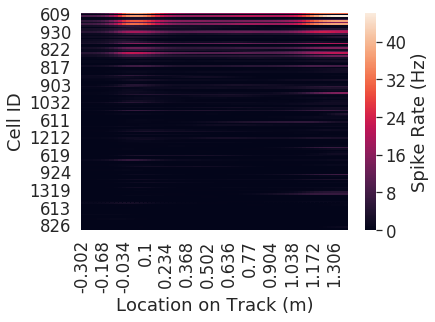

In [0]:
hm = sns.heatmap(spike_rates, cbar_kws={'label':'Spike Rate (Hz)'});

#### Note that there are actually many more cells shown here than just the dozen or so cell labels.  It is conveniently only drawing a few of the cell ID labels to declutter the screen, but you an make it draw more if you want (ask me about it).  

#### Still, this isn't very interesting yet.  The cells that fire at high rates are drowning out the signal from the ones that fire at low rates, in our figure.  And it isn't clear how to order the cells, since the cell ID is arbitrary.  We can solve a bunch of problems at once with a cool visualization called a cluster map. 

### (c)
#### First, we can normalize all the cells by computing a new "normalized" spike rate that has the same mean value across the track for every cell.  We do this by dividing through by the mean of each row, which is trickier than it sounds.  In the first line, compute the mean spike rate for each cell (each row) using the `.mean()` method on the `spike_rates` dataframe, choosing axis number 1 to compute the mean over.  (0 and 1 are the rows and columns).  

In [0]:
spike_rates_mean = spike_rates.mean(axis=1) # 0 for rows and 1 for columns
spike_rates_mean

Cell ID
609     21.082552
529      0.018499
1209    23.941240
416      0.969821
828      3.739510
119     19.536813
410      6.987747
537     20.930257
615      1.938770
819      1.703346
305      2.412509
930      8.374882
103     13.811899
1303     3.838797
532      0.163333
121      1.798297
403      0.386011
927      0.626575
417      2.453252
920     12.194316
422      0.046722
1305     1.870010
822      8.429130
1306     2.716801
931      3.749044
818     13.016543
928      2.813876
411      5.951575
1314     1.634701
1022     0.300750
          ...    
420      0.613928
1113     0.044665
803      0.072305
913      0.724345
1319     0.167522
1019     0.374178
616      0.838800
827      1.699936
516      0.210618
1316     0.082076
1035     0.012424
933      0.027576
1021     0.405936
603      0.673505
526      0.146058
613      0.041890
123      0.012104
527      0.073652
935      0.009422
102      0.059086
614      0.151050
829      0.029527
1028     0.021671
518      0.137470
80

### (d)
#### Next, we divide our original `spike_rates` by these mean spike rates. Now you need to switch the axis, because whereas we computed the mean in one direction of the dataframe, we are dividing in the other!

In [0]:
spike_rates_normalized = spike_rates.div(spike_rates_mean, axis=0)
spike_rates_normalized

Location on Track (m),-0.302,-0.275,-0.249,-0.222,-0.195,-0.168,-0.141,-0.115,-0.088,-0.061,...,1.145,1.172,1.199,1.226,1.252,1.279,1.306,1.333,1.36,1.386
Cell ID,,,,,,,,,,,,,,,,,,,,,
609,0.285314,0.290487,0.302456,0.324620,0.362618,0.425255,0.525594,0.680161,0.900224,1.169077,...,1.303022,1.408281,1.489866,1.540851,1.562707,1.561971,1.546865,1.525685,1.506198,1.494667
529,1.638702,1.519203,1.321388,1.106909,0.932279,0.833290,0.821024,0.879092,0.955493,0.963762,...,0.889672,1.538989,2.414311,3.460723,4.589474,5.713056,6.757401,7.651370,8.316035,8.673544
1209,0.360069,0.363357,0.372017,0.390060,0.423395,0.480236,0.571566,0.709682,0.899760,1.121163,...,1.294884,1.430599,1.563488,1.682109,1.778521,1.848873,1.893480,1.916612,1.925451,1.927482
416,0.467803,0.463017,0.458341,0.462415,0.486617,0.545862,0.661271,0.862296,1.179385,1.612093,...,0.813695,0.870932,0.908538,0.930163,0.946999,0.971020,1.007510,1.052046,1.093115,1.117751
828,0.171596,0.174923,0.182803,0.197825,0.224386,0.269638,0.344875,0.465816,0.646522,0.879623,...,1.635781,1.798927,1.935727,2.030640,2.081802,2.098086,2.092493,2.077172,2.061602,2.052204
119,0.302682,0.307607,0.319315,0.341517,0.379986,0.443175,0.542798,0.692182,0.896827,1.133623,...,1.366182,1.508929,1.636229,1.738014,1.812192,1.862369,1.894264,1.913267,1.923612,1.928100
410,0.346602,0.351892,0.364047,0.386359,0.424229,0.485835,0.582822,0.729089,0.932497,1.174958,...,1.225753,1.409242,1.605213,1.793911,1.954200,2.070497,2.138700,2.167075,2.171739,2.169068
537,0.354474,0.358595,0.368878,0.389340,0.426064,0.487682,0.585794,0.733135,0.933993,1.163833,...,1.394419,1.516389,1.617889,1.692653,1.742303,1.772356,1.788537,1.795508,1.797281,1.797164
615,1.155463,1.166199,1.192415,1.243770,1.335041,1.486245,1.720970,2.057211,2.479114,2.893662,...,0.121262,0.140126,0.162369,0.189526,0.223002,0.262240,0.303842,0.342319,0.371830,0.387807


### (e)
#### Now if we make the heatmap with this normalized data, we should see some patches where specific cells preferentially respond -- their receptive fields!  

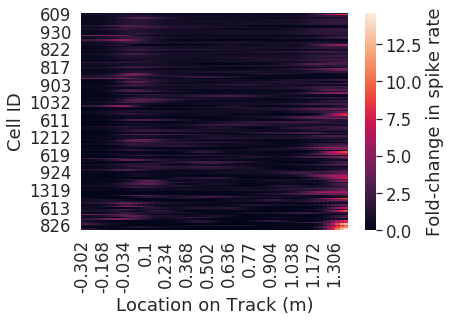

In [0]:
cm = sns.heatmap(spike_rates_normalized, cbar_kws={'label':'Fold-change in spike rate'})

#### We still don't know how the cells relate to one another (are their clusters of cells that do the same thing?) The function `sns.clustermap` takes care of this for us by hierarchically sorting the data, and does some other nice things.  For example, it can compute Z-scores, so that instead of just seeing fold-changes relative to the mean, we can see how significant the changes are in a statistical sense.  

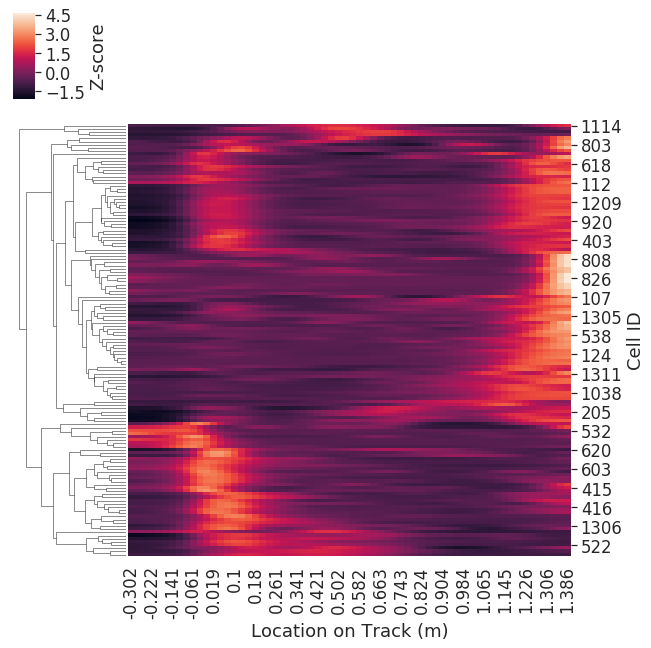

In [0]:
cm = sns.clustermap(spike_rates, # We don't even have to do the normalization, as this function will do it for us
                    col_cluster=False, # This line is to prevent the times from being clustered
                    z_score=0, # This computes Z-scores with respect to time (mean and stdev across time)
                    cbar_kws={'label':'Z-score'})

### (f)
#### One last touch: let's change the color map to make it easier to tell positive (higher rate than average) from negative (lower rate than average), and the range of colors to highlight significance levels.  For `vmin` and `vmax` set some typical significance cutoffs for a Z-score on the low and high end respectively (or ask me if you haven't seen Z-scores before).  

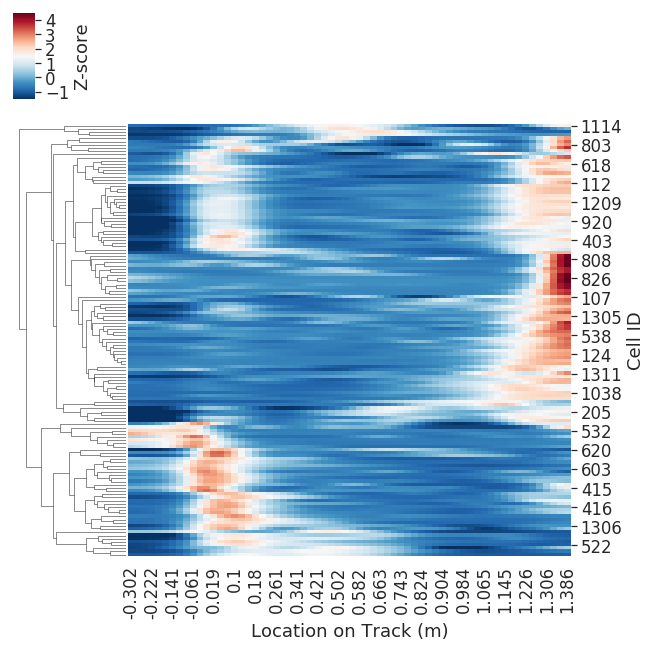

In [0]:
cm = sns.clustermap(spike_rates, 
                    vmin=-1.5, # The bluest color will be this Z-score
                    vmax=4.5, # The reddest color will be this Z-score
                    cmap='RdBu_r', # This is the name of a color map, in this case from Blue to Red
                    col_cluster=False, 
                    z_score=0, # This tells the function to compute the Z-score in each row (i.e. for each cell across track locations)
                    cbar_kws={'label':'Z-score'})

## (3)

### The figure above is pretty cool.  We can clearly see which cells are active at which parts of the track, and similarly-responding cells are grouped together.  Now let's use pieces of this figure to answer questions.  

### (a)
#### First, let's extract one cell from the `spike_rates` data that we computed earlier, in particular cell #1106 (accessible by it's integer representation).  Then let's plot it's tuning curve -- this is just a slice through the figure above, but it shows us very clearly at what part of the track this particular cell responds most.  

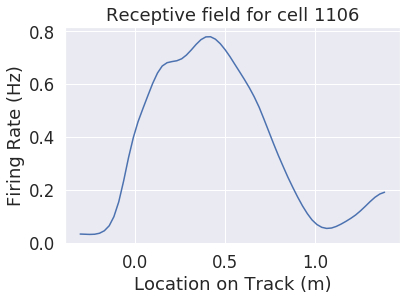

In [0]:
cell_id = 1106
one_cell_spike_rates = spike_rates.loc[1106]
one_cell_spike_rates.plot();
plt.ylabel('Firing Rate (Hz)');
plt.title('Receptive field for cell %d' % 1106);

### (b) 
#### What is the maximum firing rate for this cell (use `.max()`, and where on the track does it occur (use `.idxmax()`).  Use a print statement to write your answer.  Include units.  

In [0]:
max_value = one_cell_spike_rates.max()
max_value_id = one_cell_spike_rates.idxmax()
print("The maximum is %0.5s and it occurs at %0.5s" % (max_value, max_value_id))

The maximum is 0.778 and it occurs at 0.421


### (c)
#### Compute the width of this tuning curve, defined as the width at half of it's maximum height.  You can use a selector to extract the part that is above half of the maximum height, and then subtract the last and first values of the extract data's index (which is in units of meters).  

In [0]:
is_it_above_half_max = one_cell_spike_rates > 0.5*max_value
only_those_above_half_max = one_cell_spike_rates[is_it_above_half_max]
first_location = only_those_above_half_max.index[0] # The left-edge of the width
last_location = only_those_above_half_max.index[-1] # The right-edge of the width
print("The width is %0.5s" % (last_location - first_location))

The width is 0.75


## (4)
### (a)
#### Now let's see if we can use the tuning curves of these cells to decode the position of the rat at a given time.  This means figuring out where the rat is based only on the activity of neurons in its brain.  First, let's extract a narrow range of time (0.2 seconds) and see where the rat was over that period of time.  

In [0]:
t_begin = 19004.8
t_end = t_begin + 0.2
is_time_in_range = (locations.index>t_begin) & (locations.index<t_end)
current_locations = locations[is_time_in_range]['d'] # First elipsis to select matching rows; second elipsis to select the column contains the track location
current_locations

t
19004.808778    1.127201
19004.834378    1.098599
19004.859977    1.068989
19004.885577    1.042070
19004.911177    1.019299
19004.936777    1.004831
19004.962377    0.986472
19004.987977    0.961660
Name: d, dtype: float64

### (b)
#### Next, let's extract only the spikes that occurred in that range of time so we can figure out if they tell us anything.  

In [0]:
is_time_in_range = (spikes.index>t_begin) & (spikes.index<t_end) # First elipsis in each case is NOT `locations`, but the data frame containing spike information!
current_spikes_cell_ids = spikes[is_time_in_range]['cell_ids'] # Extract the cell_ids for spikes that occurred during this time range
current_spikes_cell_ids.head()

t
19004.80215     537
19004.80230     818
19004.80370     119
19004.80420     411
19004.80505    1209
Name: cell_ids, dtype: int64

### (c) 
#### Bayes theorem says that $p(x | s) = p(s | x) * p(x) / p(s)$
#### This means that the probability that the rate is at position `x`, given that know about some spikes `s`, is proportional to the probability of some spikes `s` having occurred at position `x`.  The term $p(s|x)/p(s)$ is basically just the normalized firing rate we computed earlier -- the probability of spiking at one position divided by the probability of spiking at any position.  We also computed the term $p(x)$ earlier -- that is just the normalized duration that the rat spends at each position.  It is pretty constant, so we can just ignore it. 
#### Let's construct our decoder using Bayes theorem.  First, let's make an empty data frame by re-using an old one and setting all the values to 0.  Then, for each cell that could helps us decode the rat's location, let's add the term $p(s | x) / p(s)$, which is just the normalized spike rate we computed earlier.  

In [0]:
decoder = spike_rates_normalized.copy() * 0
for cell_id in current_spikes_cell_ids:
   decoder.loc[cell_id] += spike_rates_normalized.loc[cell_id]

### (d)
#### Let's allow every cell to contribute equally to decoding.  Take the mean of the decoder across cells with the `.mean()` method, then plot it with the `.plot()` method.  

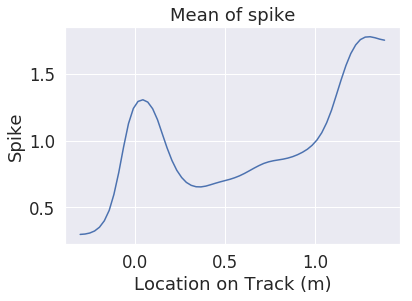

In [0]:
decoder_mean = decoder.mean()
decoder_mean.plot() # Use this line to plot
plt.ylabel('Spike');
plt.title('Mean of spike');

### (e)
#### According to our neural decoder, what is the highest probability location?  How does that compare to the rat's actual location during that time?  Do rat neurons know where they are?  

In [0]:
peak_decoder = decoder_mean.max()
peak_mean_decoder = decoder_mean.idxmax()
print("The decoder says %0.5s and the actual location is %0.5s, which are %s" % 
      (peak_mean_decoder,max_value_id , "The actual location value is 3 times less than the decoder value")) # First elipsis is deocoder peak location; second elipsis is average real location of the rat during that time period

The decoder says 1.306 and the actual location is 0.421, which are INSERT HERE SOMETHING ABOUT HOW CLOSE YOU THINK THEY ARE


#### In fact, sometimes the neurons encode where the rat is going, not where he is!  

## (5)
#### How much information can spikes convey?  We can compute information by first measuring the uncertainty that we have about location, and then figuring out how much that uncertainty is reduced by decoding some information about location from the spikes.  

### (a)
#### First, let's compute the probability distribution across locations.  Probability distributions must integrate to 1 (or sum to 1), and we achieve this by dividing the durations at each location by the total duration of the experiment.  

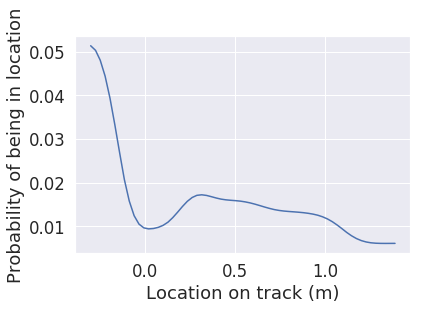

In [0]:
total_duration = durations_at_each_location.sum()
probabilty_at_each_location = durations_at_each_location / total_duration
plt.plot(bin_centers, probabilty_at_each_location)
plt.xlabel('Location on track (m)')
plt.ylabel('Probability of being in location');

### (b)
#### Next, we compute the entropy, which measures our uncertainty about location.  We divided up location into 64 bins, which is a really convenient choice for the following reason: If the rat is equally likely to be in each of the 64 location bins, then that is like flipping 6 fair coins -- there are $2^6$ possible states, and all are equally probable, therefore there are 6 bits of entropy.  

In [0]:
# Create an array of 64 values, each containing 1/64th
# This is a valid probability distribution, since it adds up to 1.  
p = np.ones(64)/64 # Hint: both elipsis are the same number!

# Compute the entropy of that distribution
h = -np.sum(p * np.log2(p))

# Report that entropy
print("The entropy is %d bits" % h)

The entropy is 6 bits


### (c)
#### Now we do this for the actual probability distribution $p(x)$ in (a)

In [0]:
p_x = probabilty_at_each_location
h = -np.sum(p_x * np.log2(p_x))
print("The entropy (uncertainty) of the rat's location is %.3g bits" % h)

The entropy (uncertainty) of the rat's location is 5.76 bits


### (d)
#### Bayes's theorem says that the conditional probability distribution p(x|s), the probability of finding the rat at location `x` given that a spike has occurred, is given by $p(x | s) = p(s | x) * p(x) / p(s)$.  p(x) is what we just looked at in (c).  $p(s | x) / p(s)$ is the normalized spike rate for the cell in question.  Let's assume that the cell that spiked is cell 1106.  Compute $p(x | s)$, and then the new entropy given that the cell spiked. 

In [0]:
p_x_s = p_x * spike_rates_normalized.loc[1106]
h_s = -np.sum(p_x_s * np.log2(p_x_s))
print("The entropy (uncertainty) of the rat's location is now only %.3g bits" % h_s)

The entropy (uncertainty) of the rat's location is now only 5.1 bits


### (e)
#### How much information was gained?  This is just the old entropy minus the new entropy, i.e. the reduction of entropy.  Information is just the reduction of uncertainty.  

In [0]:
info = h - h_s
print("The information provided by the spike about the rat's location is %.3g bits" % (info))

The information provided by the spike about the rat's location is 0.663 bits


#### Our uncertainty about the rat's location used to be about the same as that present in the outcome of 6 consecutive coin flips.  Seeing just one spike reduces that by about half a coin flip!